In [1]:
import wbdata
import pandas as pd
import tqdm
import numpy as np

from scipy.stats import norm, uniform, gaussian_kde, multivariate_normal
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from numba import njit
from see import see

In [3]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
# Components
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
import json
def txt_load(filename):
    l = []
    with open(filename, "r") as f:
        for line in f:
            l.append(line.rstrip())
    return l

def txt_dump_list(filename, item):
    with open(filename, "w") as f:
        for line in item:
            f.write(line + "\n")
    print("item saved to txt file \'"+ str(filename) +"\'")

def txt_dump_line(filename, item):
    with open(filename, "w") as f:
        f.write(item)
    print("item saved to txt file \'"+ str(filename) +"\'")

def json_load(filename):
    with open(filename, "r") as f:
        j = json.load(f)
    return j

def json_dump(filename, item):
    with open(filename, "w") as f:
        json.dump(item, f)
    print("item saved to json file \'"+ str(filename) +"\'")

In [3]:
#########################################################################################################################################################################
#　世界銀行APIからデータを取得
#########################################################################################################################################################################
def create_column(wbd,osh,target):
    l = []
    codes = json_load("country-codes.json")
    for i in range(len(osh)):
        code = osh.iloc[i]["code"]
        year = str(osh.iloc[i]["year"])
        c = codes[code]
        try:
            l.append(wbd.loc[c].loc[year][target])
        except:
            l.append("")
    return pd.DataFrame(l)

def get_df(osh, countries, indicators):
    wbd =  wbdata.get_dataframe(indicators, country=countries)
    targets = list(indicators.values())
    for item in targets:
        print("Creating column "+item)
        osh[item] = create_column(wbd,osh,item)
    return(osh)

In [165]:
codes = json_load("country-codes.json")
osh = pd.read_csv("osmarketshare_final_5.csv")
country = codes.keys()


# 取りたいデータのindicatorをここに入れる https://data.worldbank.org/indicator?tab=featured

indicator = {
"NY.GDP.MKTP.CD":"gdp",
"SP.POP.TOTL":"population",
"AG.LND.TOTL.K2":"LandArea",
"SP.POP.0014.TO.ZS":"ChildPercentage", #percentage of population 0-14 years old
"SE.XPD.TOTL.GB.ZS":"GovEduc", #政府支出における教育の割合

"SP.POP.1564.TO.ZS":"WorkingPercentage", #percentage of population 15-64 years old
"SE.COM.DURS":"EduDuration", #義務教育年数

#"SP.DYN.TFRT.IN":"Fertility rate",
#"SP.URB.TOTL.IN.ZS":"UrbanPopulation",
#"IP.JRN.ARTC.SC":"articles",
#"SL.TLF.TOTL.IN":"labor-force",
#"TX.VAL.OTHR.ZS.WT":"computer", #コンピューター・通信・その他サービス(サービス輸出比) - Computer, communications and other services (% of commercial service exports)
}

In [ ]:
#　世界銀行から任意のデータを取得
df = get_df(osh,country,indicator)
df

In [167]:
# データをCSVで保存

df.to_csv("wb_1212.csv")

In [ ]:
# CSV読み込み

df = pd.read_csv("wb_1210.csv")
df

In [ ]:
# df加工（デバイスのシェア結合）

desktop = pd.read_csv("./osmarketshare_total-desktop.csv")
desktop["year"] = [ x.split("-")[0] for x in desktop["Date"] ]
desktop["sortname"] = desktop["Country"] + desktop["year"]
desktop = desktop.groupby(by="sortname").mean()
desktop["year"] = [ int(x[-4:]) for x in desktop.index ]

In [ ]:
#　グラフ化
x="EduDuration"
y="iOS"
df[df["year"]==2020].plot.scatter(x=x, y=y)

In [84]:
##########################################################################################################################################################################################
# クロスセクション
###########################################################################################################################################################################################


df = pd.read_csv("wb_1212.csv")
df = df.sort_values(["country","year"])

# 一人当たりGDP・人口密度対数化
df["percapita"] = df["gdp"] / df["population"]
df["percapita_log"] = np.log10(df["gdp"] / df["population"] +1)
df["population_log"] = np.log10(df["population"] +1)
df["density"] = np.log10(df["LandArea"] / df["population"]+1)
df["ios"] = df["iOS"]/(df["Android"]+df["iOS"])



#Macシェア率
desktop = pd.read_csv("./osmarketshare_total-desktop.csv")
desktop["year"] = [ x.split("-")[0] for x in desktop["Date"] ]
desktop["sortname"] = desktop["Country"] + desktop["year"]
desktop = desktop.groupby(by="sortname").mean()
desktop["year"] = [ int(x[-4:]) for x in desktop.index ]

osxl = []
for x in df["sortname"]:
    osx = desktop.loc[x]["OS X"]
    osxl.append(osx)

windows = []
for x in df["sortname"]:
    win = desktop.loc[x]["Windows"]
    windows.append(win)

#言語・民族・宗教ダミー
dummies = pd.read_csv("dummies.csv")
dummies["NonReli"] = dummies["NonReli"].fillna(0)
dummies = dummies.drop(columns=["Unnamed: 0","BritanicaLink","Lang"])
ds = pd.DataFrame()
for item in df["country"].tolist():
    ds = pd.concat([ds, dummies[dummies["cs"]==item]])



df = pd.concat([
    df,ds.reset_index(), 
    pd.DataFrame(osxl, columns=["OSX"]),
    pd.DataFrame(windows, columns=["Windows"])
],axis=1)

df = df.drop(columns=["Unnamed: 0.3", "Unnamed: 0.2","Unnamed: 0.1","Unnamed: 0"])

In [237]:
# 2022年データ

df = pd.read_csv("cross-section2022_final.csv")
df["share_square"] = [ int(df.iloc[i]["iOS"])^2 + int(df.iloc[i]["Android"])^2 for i in range(len(df)) ]
df["year"] = [ df.iloc[i]["sortname"][-4:] for i in range(len(df))]
data=df[["iOS","OSX","Android","Windows","island","store","percapita_log","share_square","LangCount","EthnicCount","ReliCount"]].dropna()
for item in data.columns:
    data[item+"_island"] = data[data["island"]==1][item]
    data[item+"_not_island"] = data[data["island"]==0][item]
tbl = data.describe().transpose()



AttributeError: 'DataFrame' object has no attribute 'indexindex'

In [245]:
pd.options.display.float_format = '{:.2f}'.format
tbl

,count,mean,std,min,25%,50%,75%,max
iOS,208.00,19.79,14.77,2.27,8.33,14.96,26.34,64.36
OSX,208.00,14.85,8.75,1.44,7.89,12.58,21.06,36.85
Android,208.00,78.83,14.15,34.86,73.33,83.93,88.86,97.62
Windows,208.00,78.32,8.59,55.06,71.78,78.51,85.26,95.62
island,208.00,0.32,0.47,0.00,0.00,0.00,1.00,1.00
store,208.00,0.12,0.33,0.00,0.00,0.00,0.00,1.00
percapita_log,208.00,3.84,0.64,2.08,3.36,3.84,4.36,5.26
share_square,208.00,77.27,25.43,2.00,72.50,87.00,91.00,103.00
LangCount,208.00,1.64,1.79,1.00,1.00,1.00,2.00,23.00
EthnicCount,208.00,2.69,2.10,1.00,1.00,2.00,4.00,23.00


In [1105]:
# お試し
l = ["Iraq","Kenya","Sweden","Denmark","Nigeria","Zimbabwe","Sri Lanka","Swaziland","Bhutan","Turkmenistan","Iceland","Norway","Uganda","Northern Mariana Islands","Rwanda","Serbia","Faroe Islands","Ghana","France","Bermuda","Singapore"]
pd.options.display.float_format = '{:.4f}'.format
df = pd.DataFrame()
for x in l:
    df = pd.concat([
        df,
        data[data["country"]==x]
    ])
df.to_csv("aaa.csv")

Text(0, 0.5, 'percapita_log')

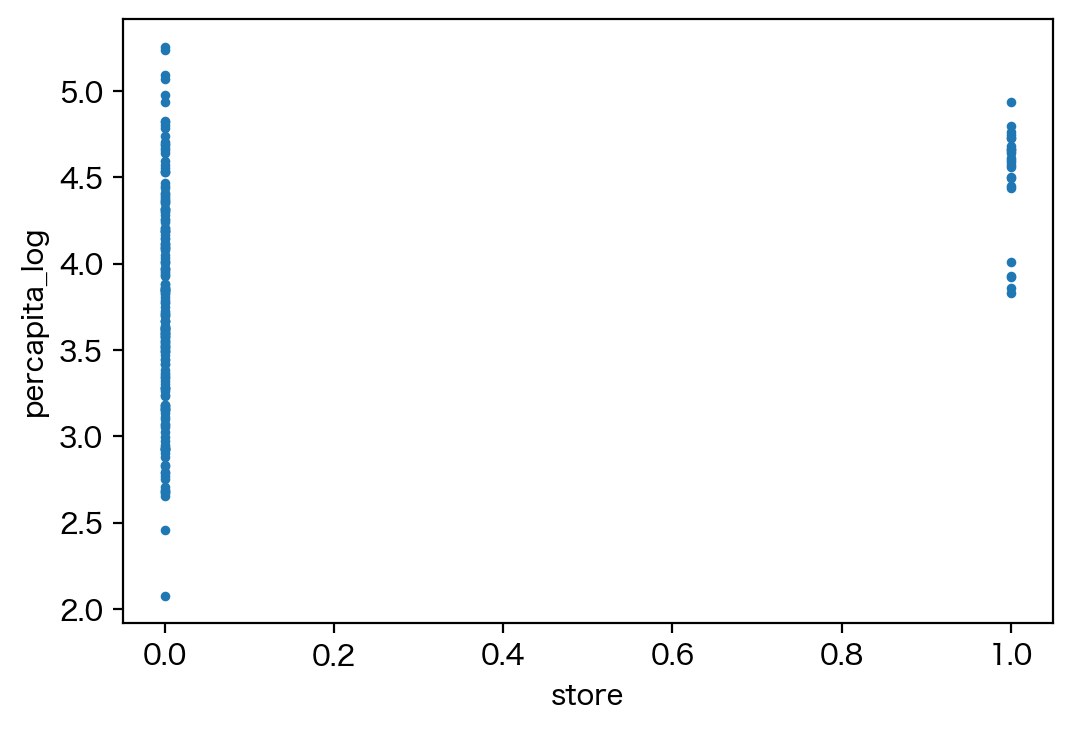

In [183]:
# グラフ描画
import numpy as np
import matplotlib.pyplot as plt

x = "store"
y = "percapita_log"

fig, ax = plt.subplots(dpi=200)
plt.scatter(data[x],data[y],s=6)
plt.title("")
plt.xlabel(x)
plt.ylabel(y)


In [233]:
l = [
    data[data["island"]==1]["iOS"].mean(),
    data[data["island"]==0]["iOS"].mean(),
    data[data["island"]==1]["Android"].mean(),
    data[data["island"]==0]["Android"].mean(),
    data[data["island"]==1]["OSX"].mean(),
    data[data["island"]==0]["OSX"].mean(),
    data[data["island"]==1]["share_square"].mean(),
    data[data["island"]==0]["share_square"].mean(),
    data[data["island"]==1]["Windows"].mean(),
    data[data["island"]==0]["Windows"].mean(),
    data[data["island"]==1]["percapita_log"].mean(),
    data[data["island"]==0]["percapita_log"].mean(),


]
l

[25.281032338417912,
 17.17555555540426,
 74.07595771149255,
 81.08184988177305,
 18.512748756432835,
 13.103965721148937,
 70.01492537313433,
 80.72340425531915,
 74.02084577074628,
 80.35601063815602,
 4.055483119253731,
 3.732921595496454]

In [230]:
# iOS
l = [
"island",
"percapita_log",
#"OSX",
#"store",
#"LangCount",
#"EthnicCount",
#"ReliCount",
#
#"NonReli"
]
formula = " iOS ~ "
for item in l:
    formula += item + " + "
formula = formula[0:-2]
l.append("iOS")
res = ols(formula, data=data[l].dropna()).fit()
txt_dump_line("1216_result2-1.csv" ,res.summary().as_csv())
res.summary()

item saved to txt file '1216_result2-1.csv'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    iOS   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     146.5
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           3.11e-40
Time:                        01:31:34   Log-Likelihood:                -762.34
No. Observations:                 208   AIC:                             1531.
Df Residuals:                     205   BIC:                             1541.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -46.7242      4.043    -11.557      0.000     -54.695     -38.753
island            2.5839      1.454      1.778      0.077      -0.282       5.450
percapita_log    17.1179      1.062     16.125      0.000      15.025      19.211
==============================================================================
Omnibus:                       20.658   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.050
Skew:                           0.742   Prob(JB):                     5.99e-06
Kurtosis:                       3.757   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [226]:
# OSX
l = [
"island",
"percapita_log",
"store",
#"iOS",
#"LangCount",
#"EthnicCount",
#"ReliCount",
#"NonReli"
]
formula = " OSX ~ "
for item in l:
    formula += item + " + "
formula = formula[0:-2]
l.append("OSX")
res = ols(formula, data=data[l].dropna()).fit()
txt_dump_line("1216_result2-2.csv" ,res.summary().as_csv())
res.summary()

item saved to txt file '1216_result2-2.csv'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    OSX   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.484
Method:                 Least Squares   F-statistic:                     65.66
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           9.32e-30
Time:                        01:27:53   Log-Likelihood:                -675.56
No. Observations:                 208   AIC:                             1359.
Df Residuals:                     204   BIC:                             1372.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -19.0068      2.842     -6.689      0.000     -24.610     -13.404
island            2.7366      0.975      2.808      0.005       0.815       4.658
percapita_log     8.5369      0.768     11.116      0.000       7.023      10.051
store             1.8038      1.472      1.226      0.222      -1.098       4.705
==============================================================================
Omnibus:                        1.254   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.534   Jarque-Bera (JB):                1.350
Skew:                           0.152   Prob(JB):                        0.509
Kurtosis:                       2.748   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [228]:
# Android
l = [
"percapita_log",
"island",
"store"
#"LangCount",
#"EthnicCount",
#"ReliCount",
#"NonReli"
]
formula = " Android ~ "
for item in l:
    formula += item + " + "
formula = formula[0:-2]
l.append("Android")
res = ols(formula, data=data[l].dropna()).fit()
txt_dump_line("1216_result2-3.csv" ,res.summary().as_csv())
res.summary()

item saved to txt file '1216_result2-3.csv'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Android   R-squared:                       0.534
Model:                            OLS   Adj. R-squared:                  0.527
Method:                 Least Squares   F-statistic:                     77.97
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           1.21e-33
Time:                        01:30:23   Log-Likelihood:                -766.29
No. Observations:                 208   AIC:                             1541.
Df Residuals:                     204   BIC:                             1554.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       132.2998      4.395     30.100      0.000     123.634     140.966
percapita_log   -13.4166      1.188    -11.294      0.000     -15.759     -11.074
island           -3.0588      1.507     -2.029      0.044      -6.031      -0.087
store            -8.4209      2.276     -3.699      0.000     -12.909      -3.933
==============================================================================
Omnibus:                       14.909   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               16.303
Skew:                          -0.682   Prob(JB):                     0.000288
Kurtosis:                       3.148   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [222]:
# Windows
l = [
"percapita_log",
"island",
#"LangCount",
#"EthnicCount",
#"ReliCount",
#"store"
#"NonReli"
]
formula = " Windows ~ "
for item in l:
    formula += item + " + "
formula = formula[0:-2]
l.append("Windows")
res = ols(formula, data=data[l].dropna()).fit()
txt_dump_line("1216_result2-4.csv" ,res.summary().as_csv())
res.summary()

item saved to txt file '1216_result2-4.csv'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Windows   R-squared:                       0.262
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                     36.33
Date:                Tue, 20 Dec 2022   Prob (F-statistic):           3.12e-14
Time:                        23:43:33   Log-Likelihood:                -710.42
No. Observations:                 208   AIC:                             1427.
Df Residuals:                     205   BIC:                             1437.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        99.7682      3.150     31.672      0.000      93.558     105.979
percapita_log    -5.2003      0.827     -6.287      0.000      -6.831      -3.570
island           -4.6578      1.132     -4.113      0.000      -6.891      -2.425
==============================================================================
Omnibus:                        3.487   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.175   Jarque-Bera (JB):                2.476
Skew:                          -0.092   Prob(JB):                        0.290
Kurtosis:                       2.498   Cond. No.                         25.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [229]:
# iOS Android
l = [
"percapita_log",
"island",
"store"
#"LangCount",
#"EthnicCount",
#"ReliCount",
]
formula = " share_square ~ "
for item in l:
    formula += item + " + "
formula = formula[0:-2]
l.append("share_square")
res = ols(formula, data=data[l].dropna()).fit()
txt_dump_line("1216_result2-5.csv" ,res.summary().as_csv())
res.summary()

item saved to txt file '1216_result2-5.csv'


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           share_square   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.292
Method:                 Least Squares   F-statistic:                     29.44
Date:                Wed, 21 Dec 2022   Prob (F-statistic):           7.35e-16
Time:                        01:30:42   Log-Likelihood:                -930.33
No. Observations:                 208   AIC:                             1869.
Df Residuals:                     204   BIC:                             1882.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       146.6403      9.672     15.162      0.000     127.571     165.710
percapita_log   -17.1843      2.614     -6.574      0.000     -22.338     -12.030
island           -5.7589      3.317     -1.736      0.084     -12.299       0.781
store           -13.1296      5.009     -2.621      0.009     -23.006      -3.254
==============================================================================
Omnibus:                       18.259   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               20.510
Skew:                          -0.698   Prob(JB):                     3.52e-05
Kurtosis:                       3.646   Cond. No.                         27.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [15]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
# パネル 月毎　VAR
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
codes = json_load("country-codes.json")

m = pd.read_csv("./osmarketshare_total.csv")
d = pd.read_csv("./osmarketshare_total-desktop.csv")

mobile = pd.DataFrame()
desktop = pd.DataFrame()


for value in list(codes.values()):
    mobile = pd.concat([
        mobile,
        m[m["Country"]==value]
    ])
    desktop = pd.concat([
        desktop,
        d[d["Country"]==value]
    ])

desktop = desktop[desktop["Date"] != "2022-11"]
mobile = mobile.reset_index().drop(columns = ["index", "Unnamed: 0"])
desktop = desktop.reset_index().drop(columns = ["index", "Unnamed: 0"]).rename(columns = {"OS X": "OSX"})

dm = {
    "iOS": "iOS_lag0",
    "Android": "Android_lag0",
}
dd = {
    "OSX": "OSX_lag0",
    "Windows": "Windows_lag0",
}

panel = pd.concat([
    mobile,
    mobile.groupby("Country")[["iOS","Android"]].diff().rename(columns = dm)
],axis=1)

panel = pd.concat([
    panel,
    desktop[["OSX","Windows"]],
    desktop.groupby("Country")[["OSX","Windows"]].diff().rename(columns = dd)
],axis=1)


In [31]:
#　iOS-OSX

codes = json_load("country-codes.json")
pd.options.display.float_format = '{:.4f}'.format
cdf = pd.DataFrame()
ex_cl = []
res = pd.DataFrame()
for c in list(codes.values()):
    df = panel[panel["Country"]==c][["iOS_lag0","OSX_lag0"]].dropna()
    df = df.reset_index().drop(columns=["index"])
    # 最大のラグ数
    maxlags = 30
    # モデルのインスタンス生成
    var_model = VAR(df)
    # 最適なラグの探索
    lag = var_model.select_order(maxlags).selected_orders
    # モデルの学習
    if lag["aic"] != 0:
        results = var_model.fit(lag["aic"])
        test_results = results.test_causality(causing=0, caused=1)  
        test_results1 = results.test_causality(causing=1, caused=0)  
        tf = False
        if test_results.pvalue<0.05:
            test_results = results.test_causality(causing=0, caused=1)  
            test_results1 = results.test_causality(causing=1, caused=0)  
            results = var_model.fit(lag["aic"])
            index_list = list(results.params.index)
            ll = "L"+ str(lag["aic"]) + "." + test_results.causing[0]
            dd = pd.DataFrame([
            [
                c,
                lag["aic"],
                test_results.causing[0].split("_")[0] + " -> " + test_results.caused[0].split("_")[0],
                results.params.loc[ll][test_results.causing[0]],
                results.tvalues.loc[ll][test_results.causing[0]],
                test_results.pvalue.round()
            ]
            ],columns=["country","lag","vector","param","t","p"])
            cdf = pd.concat([cdf,dd])

        if test_results1.pvalue<0.05:
            ll = "L"+ str(lag["aic"]) + "." + test_results1.causing[0]
            dd = pd.DataFrame([
            [
                c,
                lag["aic"],
                test_results1.causing[0].split("_")[0] + " -> " + test_results1.caused[0].split("_")[0],
                results.params.loc[ll][test_results1.caused[0]],
                results.tvalues.loc[ll][test_results1.caused[0]],
                test_results1.pvalue
            ]
            ],columns=["country","lag","vector","param","t","p"])
            cdf = pd.concat([cdf,dd])


In [ ]:
cdf[cdf["lag"]<30].sort_values(["lag","country"])

In [1087]:
cdf[cdf["lag"]<28].sort_values(["lag","country"]).to_csv("1214_ex_28.csv")

In [27]:
panel = pd.read_csv("paneldata_osmarketshare.csv")
panel.dropna()

,Unnamed: 0,Country,Date,Android,iOS,iOS_lag0,Android_lag0,OSX,Windows,OSX_lag0,Windows_lag0
1,1,Afghanistan,2009-02,0.0000,4.9900,2.6000,0.0000,2.1400,96.3900,1.0900,-0.9400
2,2,Afghanistan,2009-03,0.0000,1.6600,-3.3300,0.0000,1.5300,97.1800,-0.6100,0.7900
3,3,Afghanistan,2009-04,0.0000,3.1700,1.5100,0.0000,1.3100,97.3300,-0.2200,0.1500
4,4,Afghanistan,2009-05,0.0000,1.4200,-1.7500,0.0000,1.6900,96.8100,0.3800,-0.5200
5,5,Afghanistan,2009-06,0.0200,2.0500,0.6300,0.0200,1.5400,96.6600,-0.1500,-0.1500
...,...,...,...,...,...,...,...,...,...,...,...
34855,34855,Zimbabwe,2022-06,85.2900,12.9900,-0.5000,0.6800,4.5700,72.4400,-0.8300,0.9300
34856,34856,Zimbabwe,2022-07,84.5100,13.8500,0.8600,-0.7800,5.3500,68.6800,0.7800,-3.7600
34857,34857,Zimbabwe,2022-08,86.0500,12.4500,-1.4000,1.5400,4.7200,67.7900,-0.6300,-0.8900
34858,34858,Zimbabwe,2022-09,86.0000,12.2500,-0.2000,-0.0500,4.9700,71.8800,0.2500,4.0900


In [28]:
panel.dropna().describe().transpose().to_csv("describe_2.csv")

In [33]:
# Android-Windows
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
codes = json_load("country-codes.json")
pd.options.display.float_format = '{:.4f}'.format
cdf = pd.DataFrame()
ex_cl = []
res = pd.DataFrame()


for c in list(codes.values()):
    df = panel[panel["Country"]==c][["Android_lag0","Windows_lag0"]].dropna()
    df = df.reset_index().drop(columns=["index"])
    # 最大のラグ数
    maxlags = 36
    # モデルのインスタンス生成
    var_model = VAR(df)
    # 最適なラグの探索
    lag = var_model.select_order(maxlags).selected_orders
    # モデルの学習
    if lag["aic"] != 0:
        results = var_model.fit(lag["aic"])
        test_results = results.test_causality(causing=0, caused=1)  
        test_results1 = results.test_causality(causing=1, caused=0)  
        tf = False
        if test_results.pvalue<0.05:
            test_results = results.test_causality(causing=0, caused=1)  
            test_results1 = results.test_causality(causing=1, caused=0)  
            results = var_model.fit(lag["aic"])
            index_list = list(results.params.index)
            ll = "L"+ str(lag["aic"]) + "." + test_results.causing[0]
            dd = pd.DataFrame([
            [
                c,
                lag["aic"],
                test_results.causing[0].split("_")[0] + " -> " + test_results.caused[0].split("_")[0],
                results.params.loc[ll][test_results.causing[0]],
                results.tvalues.loc[ll][test_results.causing[0]],
                test_results.pvalue.round()
            ]
            ],columns=["country","lag","vector","param","t","p"])
            cdf = pd.concat([cdf,dd])

        if test_results1.pvalue<0.05:
            ll = "L"+ str(lag["aic"]) + "." + test_results1.causing[0]
            dd = pd.DataFrame([
            [
                c,
                lag["aic"],
                test_results1.causing[0].split("_")[0] + " -> " + test_results1.caused[0].split("_")[0],
                results.params.loc[ll][test_results1.caused[0]],
                results.tvalues.loc[ll][test_results1.caused[0]],
                test_results1.pvalue
            ]
            ],columns=["country","lag","vector","param","t","p"])
            cdf = pd.concat([cdf,dd])


In [34]:
cdf[cdf["lag"]<36].sort_values(["lag","country"])

,country,lag,vector,param,t,p
0,Chile,1,Android -> Windows,0.2977,3.8180,0.0000
0,Guam,1,Windows -> Android,-0.2587,-2.4121,0.0164
0,Nauru,1,Windows -> Android,0.2236,2.0095,0.0453
0,Nigeria,1,Android -> Windows,-0.1314,-1.5987,0.0000
0,Tajikistan,1,Windows -> Android,0.2034,2.3526,0.0192
0,Cambodia,2,Windows -> Android,0.3491,2.2918,0.0409
0,Canada,2,Android -> Windows,-0.1806,-2.1501,0.0000
0,Hungary,2,Android -> Windows,0.1182,1.3216,0.0000
0,Hungary,2,Windows -> Android,-0.2758,-2.2542,0.0039
0,Italy,2,Android -> Windows,-0.0194,-0.2367,0.0000


In [ ]:
#----------------------------------------------------------------------------------------------------------------------------------------------------------------
# （パネル 年ごと）　　
#----------------------------------------------------------------------------------------------------------------------------------------------------------------

names={
    "iOS":"iOS_lag0",
    "OSX":"OSX_lag0",
    "percapita_log":"percapita_log_lag0",
    "WorkingPercentage":"WorkingPercentage_lag0",
}

panel = pd.concat([
        df[["country","year","sortname","iOS","percapita","percapita_log","WorkingPercentage","OSX"]],
        #df.groupby("country")[["iOS", "OSX", "percapita_log", "WorkingPercentage"]].diff().rename(columns = names)
        df.groupby("country")[["iOS", "OSX", "percapita_log", "WorkingPercentage"]].diff().rename(columns = names)
    ],axis=1)

def take_lag(df,dic,lag):
    return df.groupby("country")[list(dic.keys())].shift(lag).rename(columns = dic)

for i in range(1,11):
    names = {
        "iOS_lag%s"%(i-1) : "iOS_lag%s"%i,
        "OSX_lag%s"%(i-1): "OSX_lag%s"%i,
        "WorkingPercentage_lag%s"%(i-1): "WorkingPercentage_lag%s"%i,
        "percapita_log_lag%s"%(i-1): "percapita_log_lag%s"%i
    }
    panel = pd.concat([
        panel,
        take_lag(panel, names, i)
    ],axis=1)

panel

In [ ]:
#formula = "iOS_diff ~ iOS_lag1 + OSX_lag1 "
res = ols(formula, data=panel).fit()
print(res.summary())